In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
# Data load
print('Loading Data...')
train_activity = pd.read_csv('./train/train_activity.csv', encoding='cp949')
train_label = pd.read_csv('./train/train_label.csv', encoding='cp949')
train_party = pd.read_csv('./train/train_party.csv', encoding='cp949')
train_payment = pd.read_csv('./train/train_payment.csv', encoding='cp949')
train_trade = pd.read_csv('./train/train_trade.csv', encoding='cp949')
train_guild = pd.read_csv('./train/train_guild.csv', encoding='cp949')

test_activity = pd.read_csv('./test/test_activity.csv', encoding='cp949')
test_party = pd.read_csv('./test/test_party.csv', encoding='cp949')
test_payment = pd.read_csv('./test/test_payment.csv', encoding='cp949')
test_trade = pd.read_csv('./test/test_trade.csv', encoding='cp949')
test_guild = pd.read_csv('./test/test_guild.csv', encoding='cp949')

Loading Data...


In [84]:
# 'acc_id'가 같은 row들을 하나의 row로 sum
# as_index=False  groupby를 할 때 기준이 되는 key가 사라지지 않도록 함.
# sort=False groupby 이후 자동정렬하지 않도록 함.
train_activity_sum = train_activity.groupby(['acc_id'], as_index=False, sort=False).sum() # 100000 rows × 38 columns
train_payment_sum = train_payment.groupby(['acc_id'], as_index=False, sort=False).sum()

test_activity_sum = test_activity.groupby(['acc_id'], as_index=False, sort=False).sum() 
test_payment_sum = test_payment.groupby(['acc_id'], as_index=False, sort=False).sum()

In [85]:
train_guild_copy = train_guild.copy()
test_guild_copy = test_guild.copy()

In [86]:
# Guild에 속한 ID row로 분해
# ref: https://stackoverflow.com/questions/38651008/splitting-multiple-columns-into-rows-in-pandas-dataframe
train_guild_member = train_guild_copy.guild_member_acc_id.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
train_guild_member = pd.concat([train_guild_member], axis=1, keys=['acc_id'])

test_guild_member = test_guild_copy.guild_member_acc_id.str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
test_guild_member = pd.concat([test_guild_member], axis=1, keys=['acc_id'])

In [87]:
# 기존의 guild_member_acc_id를 지우고 guild_member의 컬럼들을 추가
train_guild_copy = train_guild_copy.drop(['guild_member_acc_id'], axis=1).join(train_guild_member).reset_index(drop=True)

test_guild_copy = test_guild_copy.drop(['guild_member_acc_id'], axis=1).join(test_guild_member).reset_index(drop=True)

In [88]:
# guild_id = 0: 길드를 가입하지 않은 유저
# guild_id = 1: 길드를 가입한 유저
train_guild_act = pd.merge(train_guild_copy, train_activity_sum, how='right', sort=False).fillna(0)
mask = train_guild_act['guild_id'] != 0
column_name = 'guild_id'
train_guild_act.loc[mask, column_name] = 1

test_guild_act = pd.merge(test_guild_copy, test_activity_sum, how='right', sort=False).fillna(0)
mask = test_guild_act['guild_id'] != 0
column_name = 'guild_id'
test_guild_act.loc[mask, column_name] = 1

In [89]:
# 하나의 row로 합치기
# 길드 소속이 2개 이상인 계정 통합
train_guild_act = train_guild_act.groupby(['acc_id'], as_index=False, sort=False).mean()

test_guild_act = test_guild_act.groupby(['acc_id'], as_index=False, sort=False).mean()

# guild_id -> guild  column 이름 변경
train_guild_act = train_guild_act.rename(columns={'guild_id': 'guild'})
test_guild_act = test_guild_act.rename(columns={'guild_id': 'guild'})

In [90]:
# 길드에 소속된 계정만 출력
# train_guild_act.loc[train_guild_act['guild'] == 0]

In [91]:
# test_guild_act.loc[test_guild_act['guild'] == 0]

In [92]:
# payment 테이블 merge
train_data = pd.merge(train_guild_act, train_payment_sum.drop(columns=['payment_week']), how='outer', sort=False)

test_data = pd.merge(test_guild_act, test_payment_sum.drop(columns=['payment_week']), how='outer', sort=False)

In [93]:
encoded_labels = train_label.label.map({'week': 0, 'month': 1, '2month': 2, 'retained': 3})
train_label_en = pd.DataFrame({'label':encoded_labels, 'acc_id':train_label.acc_id})

In [94]:
# train label file encoding (scikit learn Label Encoding은 자동정렬을 하기 때문에 사용하지 않음)
# ref: https://stackoverflow.com/questions/42196589/any-way-to-get-mappings-of-a-label-encoder-in-python-pandas
# train_label_en = pd.DataFrame({'label':pd.Categorical(train_label.label,  ['week', 'month', '2month', 'retained']).labels, 'acc_id':train_label.acc_id})
# print(train_label_en)

In [95]:
# # Encoding 부분
# # Onehot Encoding을 위해 Int 형으로 데이터 변환
# label_encoder = LabelEncoder()
# int_encoded = label_encoder.fit_transform(train_label.label)
# # shape 모양 형태 변환 (#data,) -> (#data,1)
# int_encoded = int_encoded.reshape(len(int_encoded),1)

In [96]:
# onthot_encoder = OneHotEncoder(sparse=False)
# onehot_encoded = onthot_encoder.fit_transform(int_encoded)

In [97]:
# train_label_en = pd.concat([train_label, pd.DataFrame(onehot_encoded, columns=['2month', 'month', 'retained', 'week'])], axis=1)
# train_label_en = train_label_en.drop(columns=['label'])

In [98]:
train_data = pd.merge(train_data, train_label_en, sort=False)

In [99]:
# duel ratio: 승 / 참여 횟수
train_data['duel_winRatio'] = train_data['duel_win'] / train_data['duel_cnt']
train_data = train_data.drop(columns=['duel_win', 'duel_cnt'])

test_data['duel_winRatio'] = test_data['duel_win'] / test_data['duel_cnt']
test_data = test_data.drop(columns=['duel_win', 'duel_cnt'])

In [100]:
# partybattle ratio: 승 / 참여 횟수
train_data['partybattle_winRatio'] = train_data['partybattle_win'] / train_data['partybattle_cnt']
train_data = train_data.drop(columns=['partybattle_win', 'partybattle_cnt'])

test_data['partybattle_winRatio'] = test_data['partybattle_win'] / test_data['partybattle_cnt']
test_data = test_data.drop(columns=['partybattle_win', 'partybattle_cnt'])

In [101]:
# solo clear ratio: 완료 횟수 / 입장 횟수
train_data['inzone_solo_clearRatio'] = train_data['cnt_clear_inzone_solo'] / train_data['cnt_enter_inzone_solo']
train_data = train_data.drop(columns=['cnt_clear_inzone_solo', 'cnt_enter_inzone_solo'])

test_data['inzone_solo_clearRatio'] = test_data['cnt_clear_inzone_solo'] / test_data['cnt_enter_inzone_solo']
test_data = test_data.drop(columns=['cnt_clear_inzone_solo', 'cnt_enter_inzone_solo'])

In [102]:
# light clear ratio: 완료 횟수 / 입장 횟수
train_data['inzone_light_clearRatio'] = train_data['cnt_clear_inzone_light'] / train_data['cnt_enter_inzone_light']
train_data = train_data.drop(columns=['cnt_clear_inzone_light', 'cnt_enter_inzone_light'])

test_data['inzone_light_clearRatio'] = test_data['cnt_clear_inzone_light'] / test_data['cnt_enter_inzone_light']
test_data = test_data.drop(columns=['cnt_clear_inzone_light', 'cnt_enter_inzone_light'])

In [103]:
# skilled clear ratio: 완료 횟수 / 입장 횟수
train_data['inzone_skilled_clearRatio'] = train_data['cnt_clear_inzone_skilled'] / train_data['cnt_enter_inzone_skilled']
train_data = train_data.drop(columns=['cnt_clear_inzone_skilled', 'cnt_enter_inzone_skilled'])

test_data['inzone_skilled_clearRatio'] = test_data['cnt_clear_inzone_skilled'] / test_data['cnt_enter_inzone_skilled']
test_data = test_data.drop(columns=['cnt_clear_inzone_skilled', 'cnt_enter_inzone_skilled'])

In [104]:
# normal clear ratio: 완료 횟수 / 입장 횟수
train_data['inzone_nomal_clearRatio'] = train_data['cnt_clear_inzone_normal'] / train_data['cnt_enter_inzone_normal']
train_data = train_data.drop(columns=['cnt_clear_inzone_normal', 'cnt_enter_inzone_normal'])

test_data['inzone_nomal_clearRatio'] = test_data['cnt_clear_inzone_normal'] / test_data['cnt_enter_inzone_normal']
test_data = test_data.drop(columns=['cnt_clear_inzone_normal', 'cnt_enter_inzone_normal'])

In [105]:
# raid clear ratio: 완료 횟수 / 입장 횟수
train_data['raid_clearRatio'] = train_data['cnt_clear_raid'] / train_data['cnt_enter_raid']
train_data = train_data.drop(columns=['cnt_clear_raid', 'cnt_enter_raid'])

test_data['raid_clearRatio'] = test_data['cnt_clear_raid'] / test_data['cnt_enter_raid']
test_data = test_data.drop(columns=['cnt_clear_raid', 'cnt_enter_raid'])

In [106]:
# raid light clear ratio: 완료 횟수 / 입장 횟수
train_data['raid_light_clearRatio'] = train_data['cnt_clear_raid_light'] / train_data['cnt_enter_raid_light']
train_data = train_data.drop(columns=['cnt_clear_raid_light', 'cnt_enter_raid_light'])

test_data['raid_light_clearRatio'] = test_data['cnt_clear_raid_light'] / test_data['cnt_enter_raid_light']
test_data = test_data.drop(columns=['cnt_clear_raid_light', 'cnt_enter_raid_light'])

In [107]:
# bam clear ratio: 완료 횟수 / 입장 횟수
train_data['bam_clearRatio'] = train_data['cnt_clear_bam'] / train_data['cnt_enter_bam']
train_data = train_data.drop(columns=['cnt_clear_bam', 'cnt_enter_bam'])

test_data['bam_clearRatio'] = test_data['cnt_clear_bam'] / test_data['cnt_enter_bam']
test_data = test_data.drop(columns=['cnt_clear_bam', 'cnt_enter_bam'])

In [108]:
# chat: 모든 채팅 횟수의 합
train_data['chat'] = train_data['normal_chat'] + train_data['whisper_chat'] + train_data['district_chat'] + train_data['party_chat'] + train_data['guild_chat'] + train_data['faction_chat']
train_data = train_data.drop(columns=['normal_chat', 'whisper_chat', 'district_chat', 'party_chat', 'guild_chat', 'faction_chat'])

test_data['chat'] = test_data['normal_chat'] + test_data['whisper_chat'] + test_data['district_chat'] + test_data['party_chat'] + test_data['guild_chat'] + test_data['faction_chat']
test_data = test_data.drop(columns=['normal_chat', 'whisper_chat', 'district_chat', 'party_chat', 'guild_chat', 'faction_chat'])

In [109]:
# wk 활동 시기 삭제
train_data = train_data.drop(columns=['wk'])
test_data = test_data.drop(columns=['wk'])

train_data = train_data.drop(columns=['cnt_dt'])
test_data = test_data.drop(columns=['cnt_dt'])

In [110]:
# exp: 모든 경험치의 합
train_data['exp'] = train_data['npc_exp'] + train_data['npc_hongmun'] + train_data['quest_exp'] + train_data['quest_hongmun'] + train_data['item_hongmun']
train_data = train_data.drop(columns=['npc_exp', 'npc_hongmun', 'quest_exp', 'quest_hongmun', 'item_hongmun'])

test_data['exp'] = test_data['npc_exp'] + test_data['npc_hongmun'] + test_data['quest_exp'] + test_data['quest_hongmun'] + test_data['item_hongmun']
test_data = test_data.drop(columns=['npc_exp', 'npc_hongmun', 'quest_exp', 'quest_hongmun', 'item_hongmun'])

In [111]:
train_data

,acc_id,guild,play_time,game_combat_time,get_money,cnt_use_buffitem,gathering_cnt,making_cnt,payment_amount,label,...,partybattle_winRatio,inzone_solo_clearRatio,inzone_light_clearRatio,inzone_skilled_clearRatio,inzone_nomal_clearRatio,raid_clearRatio,raid_light_clearRatio,bam_clearRatio,chat,exp
0,ba86804424a9a3708b1564a7726783612a75a5b881095e...,1,2.055999,3.303208,-0.064372,-2.426116,-0.222066,4.332736,2.316438,3,...,0.948984,1.095025,0.297051,0.957992,1.327638,0.886869,1.056563,0.695391,14.999690,9.591816
1,ddea37c9b636c4b1650414052f6ede370481e9e236b193...,1,-0.642371,-0.569842,-0.023543,-0.503692,-0.027758,-0.365536,-1.199188,0,...,0.954619,0.992723,1.013358,0.990121,1.009184,0.998605,0.997774,0.695391,-0.919453,-1.567120
2,b178c21c7e3a1a404dc6b8048d719f1e33873ab8b05a41...,1,-2.910908,-2.024365,-0.153370,-1.250636,-0.222066,0.825173,0.558625,3,...,1.686654,1.059076,0.687376,1.299545,0.613881,3.415784,0.822299,0.695391,-2.014938,-4.765902
3,25810af9e9cff193561a77da73684a3113c3c1539168b1...,1,-1.988991,-2.475399,-0.185975,-2.789053,-0.222066,2.034677,-0.496063,1,...,0.954619,0.999424,0.995508,0.990121,0.946684,0.911289,1.035478,0.695391,-1.096295,-6.858369
4,464de00738deff449aabcdfe7f670e2fc0eb9fa3c9cd89...,1,0.910800,2.593565,-0.171723,2.080793,-0.222066,3.727984,-1.199188,3,...,1.008542,1.007289,0.533803,1.114397,0.808588,0.808264,1.029709,1.160394,13.386918,10.732284
5,df69740fd9b58b4353ac3d38c1ec38e7f5366a4bdbed9c...,1,5.229929,3.137308,0.061717,5.287633,-0.222066,20.902950,4.425814,3,...,0.584934,0.996285,0.365041,0.999319,1.260774,0.957240,1.008594,0.695391,50.249777,21.409978
6,37273bc48cbb089e8bc6bf3eb3e155c73e1dd745e3606e...,1,-1.373555,-0.824481,-0.179948,-1.738163,-0.222066,3.848934,0.558625,3,...,1.817717,0.980472,0.820801,0.981833,0.745139,1.953363,1.044396,1.160394,-1.050178,6.939676
7,03be59a8e01f2f5fdd42e8a74041b69f6b148257214f0c...,1,7.480646,1.806834,-0.106694,-0.958121,-0.222066,4.695588,9.734409,3,...,1.161790,0.992723,0.380965,1.028578,0.576160,0.933803,1.012268,0.695391,17.820267,42.449733
8,80562643e3d956ded3244d6ef950243578d45a74a4e007...,1,5.921157,2.220411,-0.092854,-2.079431,-0.222066,6.026043,1.261750,3,...,0.835540,1.002820,0.727982,1.002446,1.007725,0.977517,1.027486,0.695391,20.627391,14.519981
9,16b864bc8351dc9f27b738a22bbfde3b0355e3be54d191...,1,14.419799,7.250676,0.062136,1.029903,-0.222066,6.146993,17.433630,3,...,0.869041,0.986545,0.886157,1.025581,0.924732,1.073781,1.025326,0.695391,27.482478,53.865746


In [112]:
train_data = train_data[train_data.game_combat_time<50]

train_data = train_data[train_data.get_money<200]

train_data = train_data[train_data.duel_winRatio<200]
train_data = train_data[train_data.duel_winRatio>-200]

train_data = train_data[train_data.inzone_light_clearRatio<200]

train_data = train_data[train_data.inzone_skilled_clearRatio<200]
train_data = train_data[train_data.inzone_skilled_clearRatio>-200]


train_data = train_data[train_data.inzone_light_clearRatio<200]

train_data = train_data[train_data.raid_clearRatio<50]
train_data = train_data[train_data.raid_clearRatio>-50]

train_data = train_data[train_data.raid_light_clearRatio<50]

train_data = train_data[train_data.chat<500]

train_data = train_data[train_data.raid_light_clearRatio<500]


In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [114]:
train_acc_ids = train_data['acc_id'].values # save ids
X_train = train_data.drop(columns=['label', 'acc_id'])
X_train = X_train.values
Y_train = train_data[['label']].values
Y_train = Y_train.ravel()

test_acc_ids = test_data[['acc_id']].values
X_test = test_data.drop(columns=['acc_id'])
X_test = X_test.values

max_depth: 21
CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 14.4 s
0.8272346131139996
[0.41176471 0.7570028  0.76508254 0.76635982 0.73293976 0.68137696
 0.67347143 0.66736716 0.66396478 0.66563251]


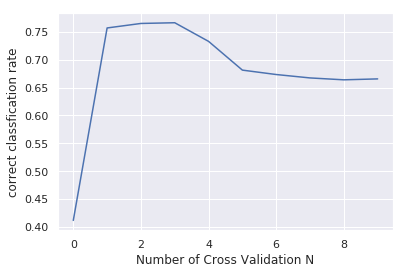

In [115]:
# RandomForestClassifier algorithm
print("max_depth: "+ str(21))
RFC = RandomForestClassifier(max_depth=21, n_estimators=100)
% time RFC = RFC.fit(X_train, Y_train)
print (RFC.score(X_train, Y_train))

# predict Y value with X_test
prediction = RFC.predict(X_test)

# validation
scores = cross_val_score(RFC, X_train, Y_train, cv=10, scoring='accuracy')
print (scores)

plt.plot(range(10), scores)
plt.xlabel('Number of Cross Validation N')
plt.ylabel('correct classfication rate')
plt.show()

In [116]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Y_pre = RFC.predict(X_train)
print(confusion_matrix(Y_train, Y_pre))
print(classification_report(Y_train, Y_pre, target_names=['0', '1','2', '3']))

[[24320   337   251    81]
 [  830 16351  7330   482]
 [  468  3097 20551   876]
 [  262   479  2773 21451]]
             precision    recall  f1-score   support

          0       0.94      0.97      0.96     24989
          1       0.81      0.65      0.72     24993
          2       0.66      0.82      0.74     24992
          3       0.94      0.86      0.90     24965

avg / total       0.84      0.83      0.83     99939



In [117]:
import seaborn as sns
sns.set()

In [118]:
train_activity.columns

Index(['wk', 'acc_id', 'cnt_dt', 'play_time', 'npc_exp', 'npc_hongmun',
       'quest_exp', 'quest_hongmun', 'item_hongmun', 'game_combat_time',
       'get_money', 'duel_cnt', 'duel_win', 'partybattle_cnt',
       'partybattle_win', 'cnt_enter_inzone_solo', 'cnt_enter_inzone_light',
       'cnt_enter_inzone_skilled', 'cnt_enter_inzone_normal', 'cnt_enter_raid',
       'cnt_enter_raid_light', 'cnt_enter_bam', 'cnt_clear_inzone_solo',
       'cnt_clear_inzone_light', 'cnt_clear_inzone_skilled',
       'cnt_clear_inzone_normal', 'cnt_clear_raid', 'cnt_clear_raid_light',
       'cnt_clear_bam', 'normal_chat', 'whisper_chat', 'district_chat',
       'party_chat', 'guild_chat', 'faction_chat', 'cnt_use_buffitem',
       'gathering_cnt', 'making_cnt'],
      dtype='object')

In [119]:
train_data.columns

Index(['acc_id', 'guild', 'play_time', 'game_combat_time', 'get_money',
       'cnt_use_buffitem', 'gathering_cnt', 'making_cnt', 'payment_amount',
       'label', 'duel_winRatio', 'partybattle_winRatio',
       'inzone_solo_clearRatio', 'inzone_light_clearRatio',
       'inzone_skilled_clearRatio', 'inzone_nomal_clearRatio',
       'raid_clearRatio', 'raid_light_clearRatio', 'bam_clearRatio', 'chat',
       'exp'],
      dtype='object')

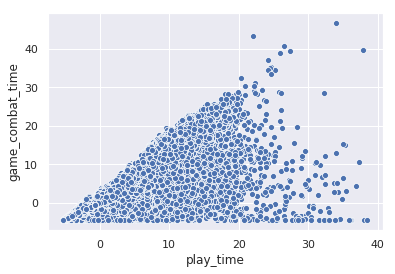

In [120]:
sns.scatterplot(x='play_time',y='game_combat_time',data=train_data)

### 길드에 소속한 User와 소속하지 않은 User 비교
0: 길드에 소속하지 않은 user

1: 길드에 소속한 user

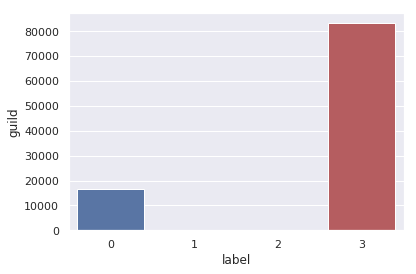

In [121]:
sns.barplot(x='label', y=train_data.guild.value_counts(), data=train_data)

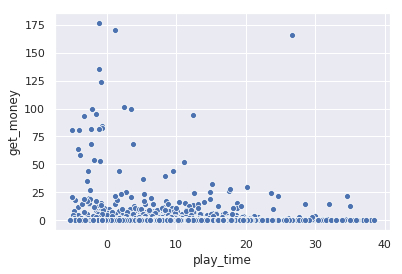

In [122]:
sns.scatterplot(x='play_time',y='get_money',data=train_data)

In [124]:
train_activity_sum = train_activity_sum[train_activity_sum.duel_cnt<400]

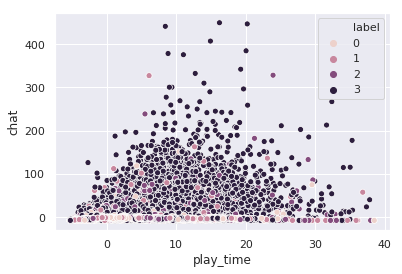

In [142]:
sns.scatterplot(x='play_time', y='chat', data=train_data, hue='label')

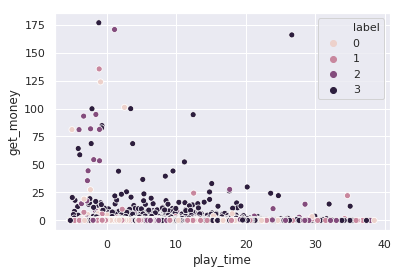

In [145]:
sns.scatterplot(x='play_time', y='get_money', data=train_data, hue='label')

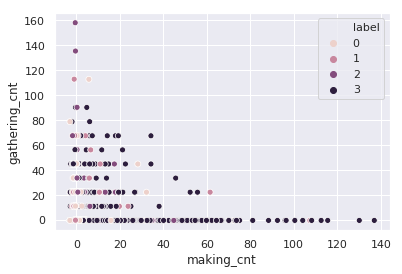

In [144]:
sns.scatterplot(x='making_cnt', y='gathering_cnt', data=train_data, hue='label')

In [ ]:
sns.scatterplot(x='play_time', y='exp', data=train_data, hue='label')

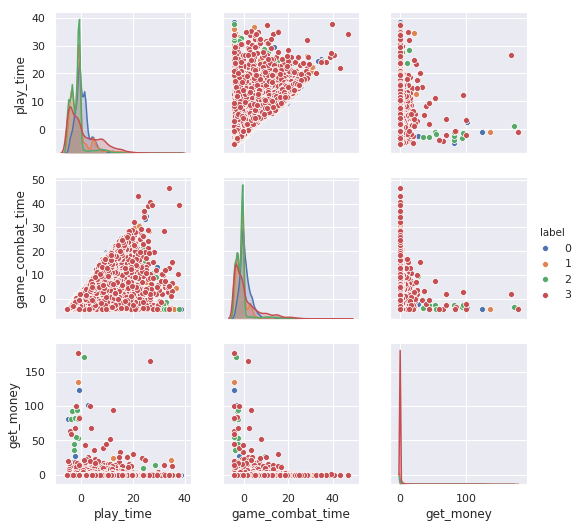

In [130]:
sns.pairplot(train_data, vars=['play_time', 'game_combat_time', 'get_money'], hue='label')

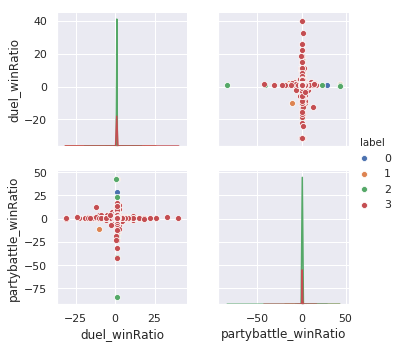

In [132]:
sns.pairplot(train_data, vars=['duel_winRatio', 'partybattle_winRatio'], hue='label')


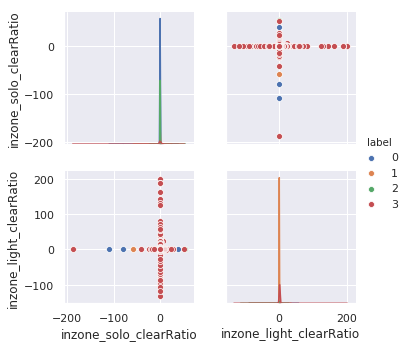

In [133]:
sns.pairplot(train_data, vars=['inzone_solo_clearRatio', 'inzone_light_clearRatio'], hue='label')

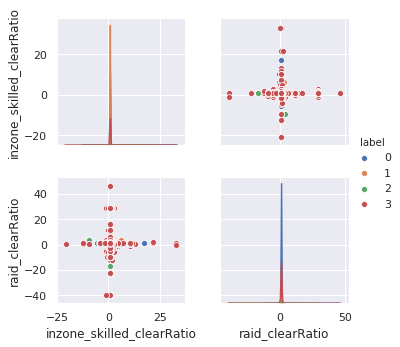

In [135]:
sns.pairplot(train_data, vars=['inzone_skilled_clearRatio', 'raid_clearRatio'], hue='label')

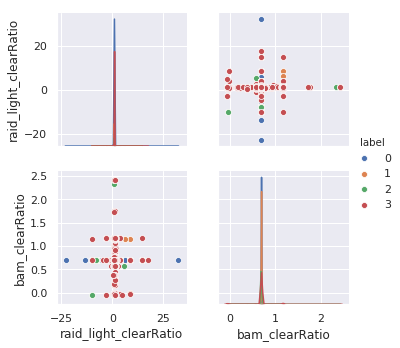

In [134]:
sns.pairplot(train_data, vars=['raid_light_clearRatio','bam_clearRatio'], hue='label')